In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA

Here are examples of loading data with different formats. 

In [3]:
import os
import json
def read_csv_space(path, file):
    return pd.read_csv(os.path.join(path, file), encoding='', sep='\s+', index_col=False, engine='python') 

def read_csv_comma(path, file):
    return pd.read_csv(os.path.join(path, file), encoding='', sep=',', engine='python') 

def json_load(path, file):
    with open(os.path.join(path, file), encoding='', mode='r') as f:
        v = json.load(f)
        f.close()
    return v

def read_text(path, file):
    with open(os.path.join(path, file),encoding='', mode='r') as f:
        lines = []
        for l in f:
            lines.append(l.rstrip('\n').split('\t'))
    return lines 

def table_load(self, path, file_name):
    df = pd.read_excel(os.path.join(path, file_name), engine='openpyxl', sheet_name=0)
    mylist = df['words'].tolist()
    return mylist

We still use the Boston housing price data for demostration. 

In [3]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) 
from sklearn.datasets import load_boston
boston=load_boston()
boston_df=pd.DataFrame(boston.data,columns=boston.feature_names)
boston_df['Price']=boston.target
xmat=boston_df.drop('Price',axis=1)
y =boston_df['Price']
X_list = xmat.columns 
print(X_list)
len(boston_df)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


506

Split data into training and test sample. 

In [4]:
X_train,X_test,y_train,y_test=train_test_split(xmat,y,test_size=0.2,random_state=3)

# Linear regression 

In [6]:
reg = LinearRegression()
reg.fit(X_train, y_train)
train_score=reg.score(X_train,y_train)
test_score=reg.score(X_test,y_test)
print(test_score)
print(reg.coef_)
yhat = reg.predict(X_test)

0.7952617563243852
[-1.23897571e-01  4.81822924e-02 -4.74497796e-02  3.36938950e+00
 -1.56635488e+01  3.59419367e+00 -9.33206067e-03 -1.47089101e+00
  3.05053544e-01 -1.08397039e-02 -9.08791339e-01  1.00352939e-02
 -4.77714677e-01]


# Lasso Regression

In [9]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print(test_score)
print(lasso.coef_)

0.7781325701654644
[-0.11469086  0.04982345 -0.09373167  1.60847689 -0.          3.51494142
 -0.01888261 -1.18575423  0.26859655 -0.01204955 -0.73803508  0.01068735
 -0.52980413]


# Ridge regression

In [8]:
ridge = Ridge(alpha=0.5)
ridge.fit(X_train,y_train)
train_score=ridge.score(X_train,y_train)
test_score=ridge.score(X_test,y_test)
coeff_used = np.sum(ridge.coef_!=0)
print(test_score)
print(ridge.coef_)

0.791190045570263
[-1.21790178e-01  4.84274483e-02 -6.67541535e-02  3.27053220e+00
 -1.10530544e+01  3.63279229e+00 -1.34407097e-02 -1.39938937e+00
  2.92168740e-01 -1.09981055e-02 -8.54768803e-01  1.02290603e-02
 -4.85349871e-01]


# Elastic net

In [9]:
elas = ElasticNet(alpha=0.5, l1_ratio=0.5)
elas.fit(X_train, y_train)
train_score=elas.score(X_train,y_train)
test_score=elas.score(X_test,y_test)
print(test_score)


0.7498390618855599


# Using K-fold cross validation (k=10) to tune the hyper parameter in Lasso regression

In [71]:
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0.001, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(xmat, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -3.378
Config: {'alpha': 0.011}


# Using K-fold cross validation to tune the two hyper parameters in elastic net

In [12]:
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0.001, 1, 0.2)
grid['l1_ratio'] = np.arange(0, 1, 0.2)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(xmat, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

An illustration of K-fold cross-validation

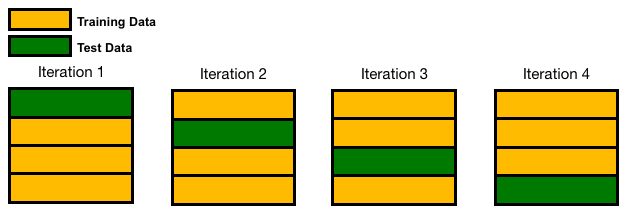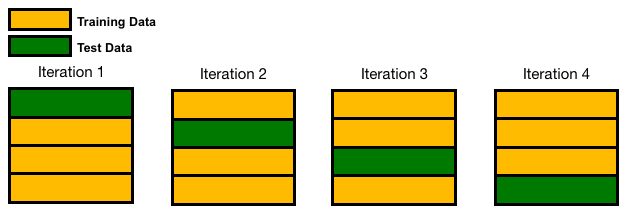

# Codes implementing K-fold cross validation from scratch

In [14]:
from sklearn.utils import shuffle
def cross_validation_split(df, folds):
    df_copy = df.copy()
    group_size = int(df_copy.shape[0] / folds)
        
    # re-ordering rows of data set randomly
    df_copy = shuffle(df_copy)
    lst = [df_copy.iloc[i:i+group_size] for i in range(0,len(df_copy),group_size)]
    if len(lst[-1]) < group_size:
        lst.pop()
    return lst 

def lasso_cv(data_groups, alpha_test):
    lasso = Lasso(alpha=alpha_test)
    scores = []
    for i in range(len(data_groups)):
        data_copy = data_groups.copy()
        test_data = data_copy[i]
        X_test = test_data[X_list]
        y_test = test_data['Price']
        data_copy.pop(i)
        training_data = pd.concat(data_copy)
        X_train = training_data[X_list] 
        y_train = training_data['Price']
        lasso.fit(X_train,y_train)
        test_score=lasso.score(X_test,y_test)
        scores.append(test_score)
    return scores


In [15]:
d = cross_validation_split(boston_df, 5)
s = lasso_cv(d, 0.5)
s

[0.7010163167652503,
 0.6838865534259895,
 0.7656393178492893,
 0.7284176429080118,
 0.575333341675984]

# Example of using Least Angel Regressin to implement Lasso


In [11]:
from sklearn.linear_model import LassoLars
model = LassoLars(alpha=0.1)
model.fit(X_train, y_train)
test_score = model.score(X_test, y_test)
model.coef_

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        2.87637518,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.29992   ,  0.        , -0.45276788])

# Examples of implementing principle component regression (PCR)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# first normalize data
sc = StandardScaler()
x = sc.fit_transform(xmat)

# now run PCA on the normalized data
pca = PCA(n_components = 12)
X_reduced = pca.fit_transform(x)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

# Now we try to develop a regression model on the components
X_train,X_test,y_train,y_test=train_test_split(X_reduced,y,test_size=0.2,random_state=3)
reg = LinearRegression()
reg.fit(X_train, y_train)
test_score=reg.score(X_test,y_test)
print(test_score)

[0.47129606 0.11025193 0.0955859  0.06596732 0.06421661 0.05056978
 0.04118124 0.03046902 0.02130333 0.01694137 0.0143088  0.01302331]
0.7793809742894393


# Example of Partial Least Squares in Python

In [8]:
# Reload the data
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) 
from sklearn.datasets import load_boston
boston=load_boston()
boston_df=pd.DataFrame(boston.data,columns=boston.feature_names)
boston_df['Price']=boston.target
xmat=boston_df.drop('Price',axis=1)
y =boston_df['Price']
X_train,X_test,y_train,y_test=train_test_split(xmat,y,test_size=0.2,random_state=3)

from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=8)
pls.fit(X_train, y_train)
pls.score(X_test, y_test)

0.7940562042769597